# Sentiment Analysis of Product Reviews

This notebook demonstrates how to analyze sentiment in product reviews and visualize trends over time.

We'll cover:
1. Loading and preparing review data
2. Performing sentiment analysis using a pre-trained model
3. Analyzing sentiment trends over time
4. Visualizing the impact of major events (like the pandemic) on sentiment

*Note: This tutorial uses Hugging Face Transformers and requires GPU support for optimal performance.*

## 1. Setting Up Our Environment

First, let's import the libraries we need for our analysis:

In [52]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from transformers import pipeline  # Hugging Face transformers for sentiment analysis
from tqdm.notebook import tqdm  # Progress bars for notebooks

# Set up visual style for better-looking plots
plt.style.use('seaborn-v0_8-whitegrid')  # Clean style with grid
plt.rcParams['figure.figsize'] = (12, 6)  # Default figure size

## 2. Loading and Preparing the Data

We'll work with a dataset of product reviews that includes text content, ratings, and dates. Let's load and prepare this data for analysis.

In [ ]:
# Load the reviews dataset
print("Loading reviews data...")
reviews = pd.read_csv('Bitcoin_tweets.csv')

# Display the first few rows to understand the structure
reviews.head()

Loading reviews data...


### Data Cleaning and Preparation

Now let's clean and prepare our data:
1. Extract and convert dates to a proper datetime format
2. Convert ratings to numeric values
3. Remove records with missing values
4. Focus on a specific time period

In [54]:
# Clean and prepare the data

# 1. Extract date from the string format and convert to datetime
# The dates are in a format like "Reviewed in the United States on June 23, 2020"
reviews['Date'] = pd.to_datetime(
    reviews['Date'].str.extract(r'on (.+?(?:\)|$))', expand=False),
    errors='coerce'  # Handles any parsing errors by setting them to NaT
)

# 2. Convert ratings to numeric values
reviews['Rating'] = pd.to_numeric(reviews['Rating'], errors='coerce')

# 3. Remove rows with missing dates
reviews = reviews.dropna(subset=['Date'])

# 4. Focus on recent years for better analysis (2018 onward)
reviews = reviews[reviews['Date'] >= '2018-01-01']

print(f"Working with {len(reviews)} reviews")

# Check our data after cleaning
reviews.info()

Working with 21817 reviews
<class 'pandas.core.frame.DataFrame'>
Index: 21817 entries, 0 to 31175
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Title        19786 non-null  object        
 1   Author       21815 non-null  object        
 2   Date         21817 non-null  datetime64[ns]
 3   Rating       21817 non-null  int64         
 4   Product      21697 non-null  object        
 5   Helpfulness  2937 non-null   object        
 6   Content      21817 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 1.3+ MB


Let's also check the distribution of ratings to understand our data better:

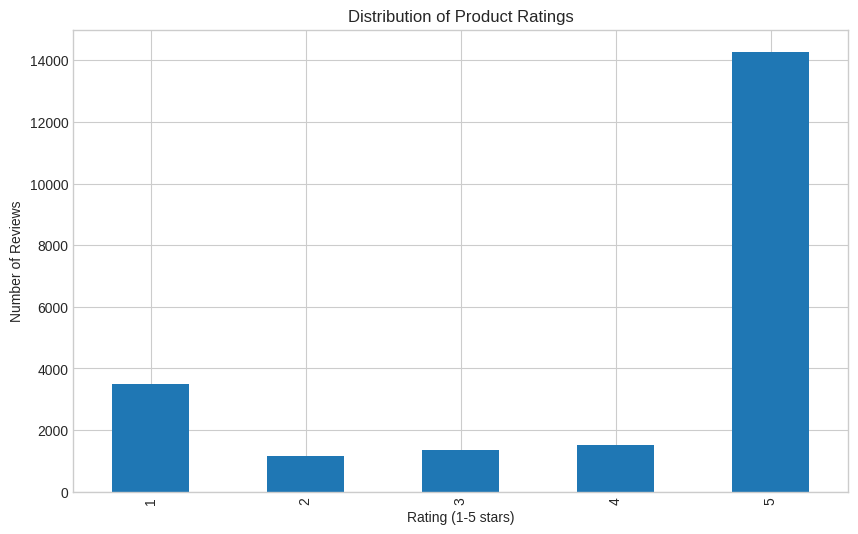

In [55]:
# Distribution of ratings
plt.figure(figsize=(10, 6))
reviews['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Product Ratings')
plt.xlabel('Rating (1-5 stars)')
plt.ylabel('Number of Reviews')
plt.show()

## 3. Setting Up Sentiment Analysis

Now we'll use a pre-trained model from Hugging Face to analyze the sentiment of each review. We'll use `distilbert-base-uncased-finetuned-sst-2-english`, which is a lightweight model trained for sentiment analysis.

### What is DistilBERT?
DistilBERT is a smaller, faster version of BERT that retains 97% of its language understanding capabilities while being 40% smaller and 60% faster. It's perfect for applications where computational resources are limited.

In [115]:
# Initialize the sentiment analysis model
print("Setting up sentiment analysis model...")
sentiment_analyzer = pipeline("text-classification", model="mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"),
device='cuda'  # Use GPU for faster processing

Setting up sentiment analysis model...


config.json:   0%|          | 0.00/933 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0


In [103]:
infile = open('Bitcoin_tweets.csv', 'r')
for i, line in enumerate(infile):
    if i == 0:
        continue
    else:
        stuff = line.split(',')
        print(stuff[2])
    if i == 3:
        break
        print(line.strip())

 GA"
😎 BITCOINLIVE is a Dutch platform aimed at informing the general public about crypto & technology! 😉 AND promoting it: https://t.co/5RYdRnUSud
 England"


### Creating our Sentiment Analysis Function

We'll define a function that takes a text input and returns a sentiment score between -1 and 1:
- Positive scores (0 to 1) indicate positive sentiment
- Negative scores (-1 to 0) indicate negative sentiment
- 0 represents neutral sentiment

In [119]:


def analyze_sentiment(text):
    """
    Analyze the sentiment of a text and return a score between -1 and 1.
    -1 is most negative, 1 is most positive.

    Parameters:
    -----------
    text : str
        The review text to analyze

    Returns:
    --------
    float
        Sentiment score between -1 and 1
    """
    # Handle potential issues with text data
    if not isinstance(text, str) or not text.strip():
        return 0  # Neutral sentiment for empty text

    # Truncate long texts to avoid token limit errors (models typically have limits)
    max_length = 500
    if len(text) > max_length:
        text = text[:max_length]

    try:
        # Get sentiment prediction from model
        result = sentiment_analyzer(text)
        print(result)

        # Convert model output to a score between -1 and 1
        if result[0]['label'] == 'POS':
            return result[0]['score'] * 1.0  # Positive score (0 to 1)
        else:
            return -result[0]['score'] * 1.0  # Negative score (-1 to 0)
    except Exception as e:
        print(f"Error analyzing text: {e}")
        return 0  # Return neutral on error

# Let's test our function with a few examples


for idx, row in reviews.iterrows():
    print(row("text"))
    sentiment = analyze_sentiment(row["text"]) # Assuming 'example' is defined somewhere
    print(row["text"])
    print(sentiment)
    print('---')
    break

TypeError: 'Series' object is not callable

## 4. Analyzing Review Sentiments

Now we'll analyze the sentiment of each review in our dataset. We'll process them in batches for better performance.

In [58]:
# Process the reviews in batches
print("Analyzing sentiments...")
batch_size = 32  # Process 32 reviews at a time for better memory usage
sentiment_scores = []

# Process each batch of reviews with a progress bar
for i in tqdm(range(0, len(reviews), batch_size)):
    # Get a batch of reviews
    batch = reviews.iloc[i:i+batch_size]

    # Analyze sentiment for each review in the batch
    batch_sentiments = [analyze_sentiment(str(text)) for text in batch['Content'].fillna('')]

    # Store the results
    sentiment_scores.extend(batch_sentiments)

# Add sentiment scores to the dataframe
reviews['sentiment_score'] = sentiment_scores

Analyzing sentiments...


  0%|          | 0/682 [00:00<?, ?it/s]

### Comparing Rating vs. Sentiment

Let's see how the explicit ratings (1-5 stars) correlate with our sentiment analysis scores (-1 to 1):

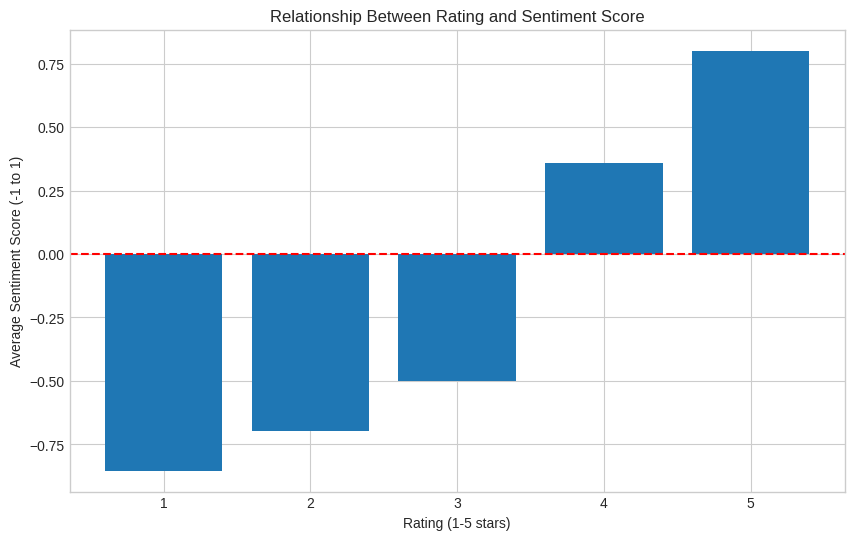

In [59]:
# Calculate average sentiment score for each rating
sentiment_by_rating = reviews.groupby('Rating')['sentiment_score'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(sentiment_by_rating['Rating'], sentiment_by_rating['sentiment_score'])
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Rating (1-5 stars)')
plt.ylabel('Average Sentiment Score (-1 to 1)')
plt.title('Relationship Between Rating and Sentiment Score')
plt.xticks([1, 2, 3, 4, 5])
plt.show()

## 5. Time Series Analysis

Now let's analyze how sentiment changes over time. We'll group reviews by month and calculate the average sentiment for each month.

In [60]:
# Group reviews by month for time series analysis
reviews['year_month'] = reviews['Date'].dt.to_period('M')
monthly_sentiment = reviews.groupby('year_month').agg({
    'sentiment_score': 'mean',  # Average sentiment per month
    'Rating': 'mean',           # Average rating per month
    'sentiment_score': [        # Count reviews and calculate standard deviation
        'count',                # Number of reviews per month
        'std'                   # Standard deviation of sentiment scores
    ]
}).reset_index()

# Flatten the column names
monthly_sentiment.columns = ['year_month', 'avg_rating', 'review_count', 'sentiment_std']
monthly_sentiment['avg_sentiment'] = reviews.groupby('year_month')['sentiment_score'].mean().values

# Convert period to timestamp for plotting
monthly_sentiment['year_month'] = monthly_sentiment['year_month'].dt.to_timestamp()

# Calculate a 3-month rolling average to smooth out the trend line
monthly_sentiment['sentiment_rolling_avg'] = monthly_sentiment['avg_sentiment'].rolling(
    window=3,      # 3-month window
    min_periods=1  # Use at least 1 value (for the first two months)
).mean()

# Display the first few months of data
monthly_sentiment.head()

,year_month,avg_rating,review_count,sentiment_std,avg_sentiment,sentiment_rolling_avg
0,2018-01-01,538,0.818390,4.239777,0.548284,0.548284
1,2018-02-01,486,0.789571,4.304527,0.597273,0.572779
2,2018-03-01,552,0.833318,4.161232,0.520962,0.555507
3,2018-04-01,430,0.838361,4.209302,0.525196,0.547811
4,2018-05-01,286,0.932067,3.965035,0.328550,0.458236


## 6. Visualizing Sentiment Trends Over Time

Now we'll create a visualization of sentiment trends over time, highlighting the impact of the COVID-19 pandemic.

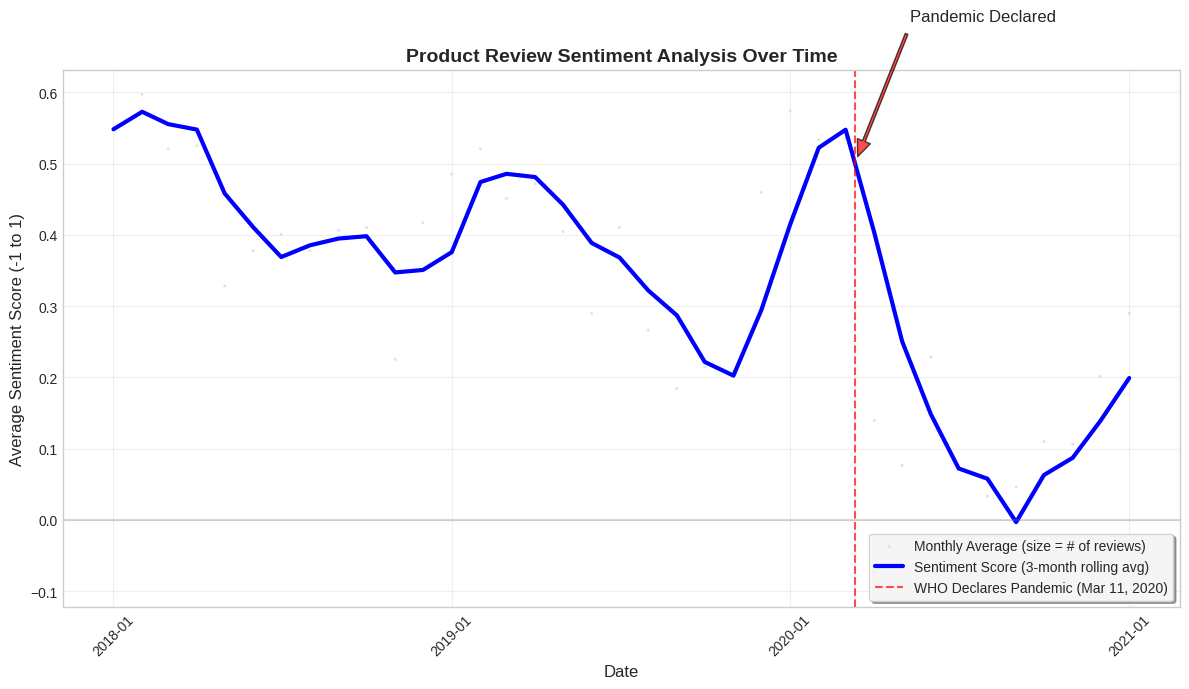

In [61]:
# Create the time series visualization
plt.figure(figsize=(12, 7))

# Plot the raw sentiment data as light dots
plt.scatter(monthly_sentiment['year_month'], monthly_sentiment['avg_sentiment'],
           alpha=0.4, color='lightblue', s=monthly_sentiment['review_count']*2,
           label='Monthly Average (size = # of reviews)')

# Plot sentiment rolling average as a line
plt.plot(
    monthly_sentiment['year_month'],
    monthly_sentiment['sentiment_rolling_avg'],
    'b-',      # Blue solid line
    linewidth=3,
    label='Sentiment Score (3-month rolling avg)'
)

# Add horizontal line at y=0 (neutral sentiment)
plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)

# Add vertical line for start of pandemic
pandemic_date = pd.Timestamp('2020-03-11')  # WHO declared pandemic on March 11, 2020
plt.axvline(
    x=pandemic_date,
    color='red',
    linestyle='--',
    alpha=0.7,
    label='WHO Declares Pandemic (Mar 11, 2020)'
)

# Add text annotation for the pandemic
plt.annotate('Pandemic Declared',
             xy=(pandemic_date, 0.5),
             xytext=(pandemic_date + pd.Timedelta(days=60), 0.7),
             arrowprops=dict(facecolor='red', shrink=0.05, width=2, headwidth=10, alpha=0.7),
             fontsize=12)

# Add labels and formatting
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Sentiment Score (-1 to 1)', fontsize=12)
plt.title('Product Review Sentiment Analysis Over Time', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)  # Light grid for readability

# Format the x-axis to show years clearly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=45)

# Add legend with a shadow effect
plt.legend(loc='lower right', frameon=True, framealpha=0.9, shadow=True)

plt.tight_layout()  # Adjust layout for better display
plt.savefig('sentiment_analysis.png', dpi=300)  # Save high-resolution image
plt.show()

## 7. Analysis and Interpretation

Now let's analyze our findings. We'll look at average sentiment before and after the pandemic declaration.

In [62]:
# Define pre and post pandemic periods
pandemic_date = pd.Timestamp('2020-03-11')
pre_pandemic = reviews[reviews['Date'] < pandemic_date]
post_pandemic = reviews[reviews['Date'] >= pandemic_date]

# Calculate average sentiment for each period
pre_avg = pre_pandemic['sentiment_score'].mean()
post_avg = post_pandemic['sentiment_score'].mean()

print(f"Pre-pandemic average sentiment: {pre_avg:.4f}")
print(f"Post-pandemic average sentiment: {post_avg:.4f}")
print(f"Change: {post_avg - pre_avg:.4f}")

# Calculate statistical significance (simple t-test)
from scipy import stats
t_stat, p_value = stats.ttest_ind(pre_pandemic['sentiment_score'], post_pandemic['sentiment_score'])
print(f"\nStatistical test:")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Statistically significant difference: {p_value < 0.05}")

Pre-pandemic average sentiment: 0.4486
Post-pandemic average sentiment: 0.1253
Change: -0.3233

Statistical test:
t-statistic: 24.5487
p-value: 0.0000
Statistically significant difference: True


## 8. Saving Our Results

Finally, let's save our processed data for future reference or further analysis.

In [63]:
# Save the processed data
sentiment_results = reviews[['Date', 'Rating', 'sentiment_score']]
sentiment_results.to_csv('sentiment_results.csv', index=False)
print("Data saved to sentiment_results.csv")

# Save the monthly aggregated data
monthly_sentiment.to_csv('monthly_sentiment.csv', index=False)
print("Monthly data saved to monthly_sentiment.csv")

Data saved to sentiment_results.csv
Monthly data saved to monthly_sentiment.csv


## 9. Conclusion and Discussion

In this notebook, we've demonstrated how to:

1. Load and preprocess product review data
2. Use a pre-trained transformer model to analyze sentiment
3. Visualize sentiment trends over time
4. Examine the potential impact of a major event (the pandemic) on product reviews